In [1]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-kkpirtbv
  Running command git clone --filter=blob:none --quiet https://github.com/PYFTS/pyFTS /tmp/pip-req-build-kkpirtbv
  Resolved https://github.com/PYFTS/pyFTS to commit 4e0ee7cdd9fc9a8ac9170c0c3496536ef0378cb7
  Preparing metadata (setup.py) ... done
  Created wheel for pyFTS: filename=pyFTS-1.7-py3-none-any.whl size=219432 sha256=1d60ee577f3bab82012a9826a69bdd336554cfcf933db4f769fcbf7a76930eb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-apou2vfj/wheels/7f/25/75/dd8f713bf48592da71e0441c7abdc1f5aa4d9645a6b7ee99d4
Successfully built pyFTS


In [2]:
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import matplotlib.pylab as plt
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Load dữ liệu và chia train, test. val
data = pd.read_csv('/content/drive/MyDrive/CVX.csv')
data_actual = pd.read_csv('/content/drive/MyDrive/CVX.csv')
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

input_df = train_data[['Date', 'Close']]
input_df_test = test_data[['Date', 'Close']]
input_df_val = val_data[['Date', 'Close']]
input_actual = data_actual[['Date', 'Close']]

input_df = input_df.set_index('Date')
input_df_test = input_df_test.set_index('Date')
input_df_val = input_df_val.set_index('Date')
input_actual = data_actual.set_index('Date')

data_actual = input_actual.Close.values
train_data = input_df.Close.values
test_data = input_df_test.Close.values
val_data = input_df_val.Close.values

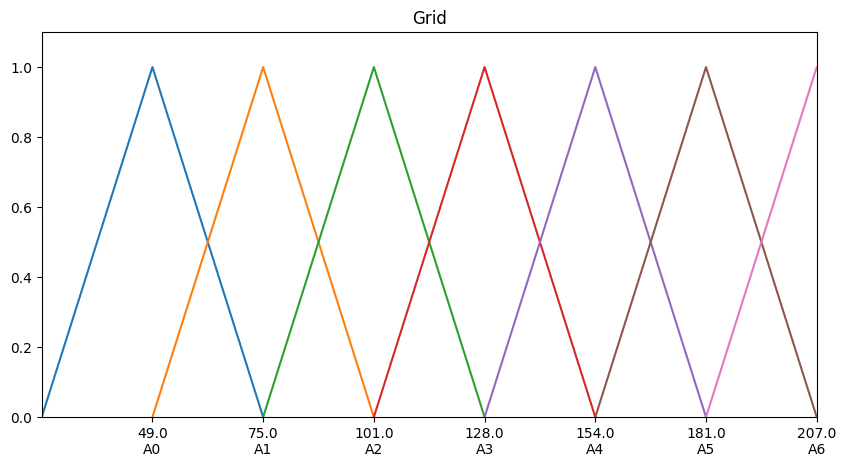

In [4]:
#Chia dữ liệu thành 7 phần (7 tập mờ)
from pyFTS.partitioners import Grid
fs = Grid.GridPartitioner(data=data_actual,npart=7)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,5])
fs.plot(ax)

In [5]:
fuzzyfied = fs.fuzzyfy(data_actual, method='maximum', mode='sets')

In [6]:
from pyFTS.common import FLR
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A3 -> A3', 'A3 -> A2', 'A2 -> A3', 'A2 -> A2', 'A2 -> A1', 'A1 -> A1', 'A1 -> A0', 'A0 -> A0', 'A0 -> A1', 'A1 -> A2', 'A3 -> A4', 'A4 -> A4', 'A4 -> A5', 'A5 -> A4', 'A5 -> A5', 'A4 -> A3']


In [7]:
#train model với tập train
from pyFTS.models import chen
model = chen.ConventionalFTS(partitioner=fs)
model.fit(train_data)
print(model)

Conventional FTS:
A0 -> A0,A1
A1 -> A0,A1,A2
A2 -> A1,A2,A3
A3 -> A2,A3



In [8]:
#Kiểm tra trên tập test
y_pred = model.predict(test_data)

#Kiểm tra trên tập val
y_pred_val = model.predict(val_data)

In [9]:
from datetime import timedelta
import pandas as pd
last_date = pd.to_datetime(input_df_val.index[-2])
# Tạo DataFrame mới với 30 dòng và cột 'Date'
new_dates = pd.date_range(last_date + timedelta(days=1), periods=30, freq='D')
index_next_30 = pd.DataFrame({'Date': new_dates})
index_next_30 = index_next_30.set_index('Date')

#dự đoán 30 ngày kế tiếp dựa vào ngày cuối cùng
predicted_values = model.predict(val_data[-1:], steps_ahead=30)
print(predicted_values)

[180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667, 180.5121695666667]


In [12]:
fig = px.line()
fig.add_scatter(x=input_df.index, y=train_data, name='Train')
fig.add_scatter(x=input_df_test.index, y=test_data, name='ActualTest')
fig.add_scatter(x=input_df_test.index[1:], y=y_pred, name='PredictedTest')
fig.add_scatter(x=input_df_val.index, y=val_data, name='ActualValidate')
fig.add_scatter(x=input_df_val.index[1:], y=y_pred_val, name='PredictedValidate')
fig.add_scatter(x=index_next_30.index[1:], y=predicted_values, name='Next30Days')
fig.update_layout(
    title='Fuzzy Time series 7:2:1 (CVX Stock Price)',
    xaxis_title='X-axis',
    yaxis_title='Y-axis',
    width=800,
    legend=dict(
        orientation="v",  # Hiển thị chú thích ngang phía dưới biểu đồ
        yanchor="top",
        y=0.35,
        xanchor="left",
        x=0
    )
)

fig.show()


In [11]:
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((val_data[1:]- y_pred_val[:-1]) ** 2))

test_rmse = np.sqrt(np.mean((test_data[1:] - y_pred[:-1]) ** 2))

valid_mape = calculate_mape(val_data[1:], y_pred_val[:-1])
test_mape = calculate_mape(test_data[1:], y_pred[:-1])

valid_mda = calculate_mda(val_data[1:], y_pred_val[:-1])
test_mda = calculate_mda(test_data[1:], y_pred[:-1])

# In kết quả
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 7.352026269326152
Testing RMSE: 11.138754950125863
Validation MAPE: 3.6912460380984773
Testing MAPE: 6.463277755087315
Validation MDA: 1.5037593984962405
Testing MDA: 7.169811320754717
